<a href="https://colab.research.google.com/github/AmirMoazzami/207_final_project/blob/main/Zillow_streamlined_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Zillow Prize: Zillow’s Home Value Prediction

* Gray Selby
* Amir Moazami
* Soroush Yazdani

<font color='red'> As extensive data cleaning was necessary, we have prepared a separate notebook named "Zillow_feature_selection_at_length.ipynb." In this notebook, you'll find the classes and methods utilized during the data cleaning process. Consequently, the primary notebook that showcases our work will be this one. </font>

In this competition, Zillow has requested participants to predict the log-error between their Zestimate and the actual sale price of homes, using all available features. The log error is calculated as the logarithm of the Zestimate divided by the logarithm of the SalePrice:

**logerror = log(Zestimate) - log(SalePrice)**

We have been provided with a comprehensive dataset containing real estate properties from three counties in California: Los Angeles, Orange, and Ventura, for the year 2016.

The training data consists of all property transactions that occurred before October 15, 2016, as well as some transactions that took place after that date.

The test data available in the public leaderboard includes the remaining transactions that occurred between October 15 and December 31, 2016.

The rest of the test data, which is used to calculate the private leaderboard scores, encompasses all the properties sold between October 15, 2017, and December 15, 2017. This particular period is referred to as the "sales tracking period," during which no submissions will be accepted.

Our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

When a property is sold multiple times within a 31-day period, we will consider the first reasonable value as the ground truth. The notion of "reasonable" entails selecting the transaction with a value that appears more accurate if the data seems questionable.

To begin, we will import the necessary libraries and obtain the dataset from Kaggle.com. Subsequently, we will conduct exploratory data analysis (EDA) to enhance the cleanliness of the dataset. Finally, we will employ some machine learning techniques to establish the best model.









# Datasets (Porperties for 2016 Data)
Zillow has provided us with two datasets for the years 2016 and 2017. To establish a baseline model, we will initially focus on the 2016 data. Once we have gained confidence in our approach and model performance, we can then incorporate the 2017 data into our analysis. This stepwise approach allows us to first ensure the effectiveness of our methodology before expanding it to include additional data.

In [1]:
# Import the libraries we'll use below.
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set numpy random dseed
np.random.seed(42)
# instantiate numpy random number generator
rng = np.random.default_rng(42)

In [ ]:
# Import our utilities.py file
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

The data was saved and shared on a google drive so everyone have access to them.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Instantiate
ZD = ZillowData(r"/content/drive/MyDrive/W207_Zillow/zillow-prize-1/")
# Instantiate (Amir)
#ZD = ZillowData("/pa/home/amir.moazami/Projects/207/final_proj/Zillow_Dataset")

In the next section, we will examine the dataset and perform data analysis to gain insights. Due to the large size of the data, it is necessary to conduct exploratory data analysis (EDA) in order to clean and preprocess it effectively

# Load the Data

In this section, our objective is to conduct exploratory data analysis (EDA) in order to gain a deeper understanding of the relationships between the variables. We will begin by addressing missing values by substituting them with the medians of their respective columns. Following that, we will generate a correlation coefficient plot to examine the correlations between the variables. This analysis will provide valuable insights into the interdependencies among the variables and aid in our subsequent modeling and decision-making processes.

The data cleaning has been done in another notebook due to its large size of the cleaning. Please check the method get_data() in utilities.py for the implementation.

In [ ]:
# loading the data using the utitilities.py library
ZD.get_data()
ZD.data.info()

### Check for duplicate entries

There were numerous ParcelIDs that they were repeated many time. The houses didn't sell and they showed up again in the market again. Therefore, we only picked the last transaction data and omit the duplicate ones.

In [ ]:
ZD.check_for_duplicates()

Number of duplicates IDs: 0 / 167888


# Train, Validation, Test Split

The data will be splitted right at the begining. This is done to make sure all of the ML models uses the same data. We have ensured that each row is unique so we will randomly select 70% of the rows for the train set and split the remaining rows between validation and test sets.

In [ ]:
ZD.train_val_test_split(train_prob=0.7)

Train set ratio: 0.70
Validation set ratio: 0.15
Test set ratio: 0.15


# Baseline Targets

The baseline data initially was selected to be CNN. However, after further investigation, we decided to pick the Mean Absolute Error (MAE) and Mean Squared Error (MSE) of the output parameter for the whole data set. This actually was more solid way to represent the baseline of logerror (label paramater).

So let's calculate the MAE and MSE as below:

In [ ]:
# Mean absolute error
ZD.train.logerror.mad()

0.06971411951878244

In [ ]:
# Mean squared error
ZD.train.logerror.std()

0.1653561609472707

## The regression prediction targets

Due to the nature of the outliers, the dataset was has high logerror width and that cause a lot of unaccurate predictions. So data set need to be normalized. Let's start with showing the distribution of the logerrors:

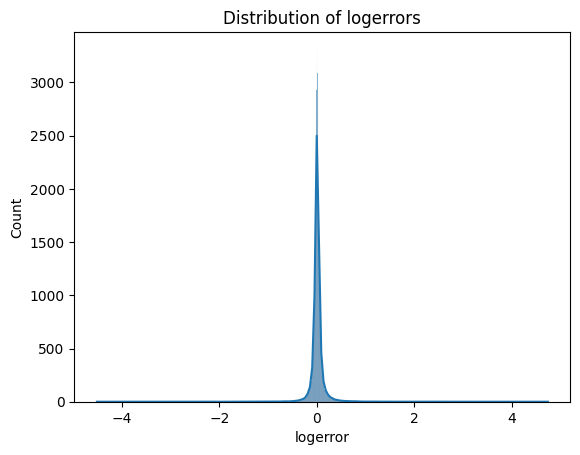

In [ ]:
ZD.plot_logerr_hist(df=ZD.train)

Now, let's plot the Q-Q plot and see how outliers are showing up:

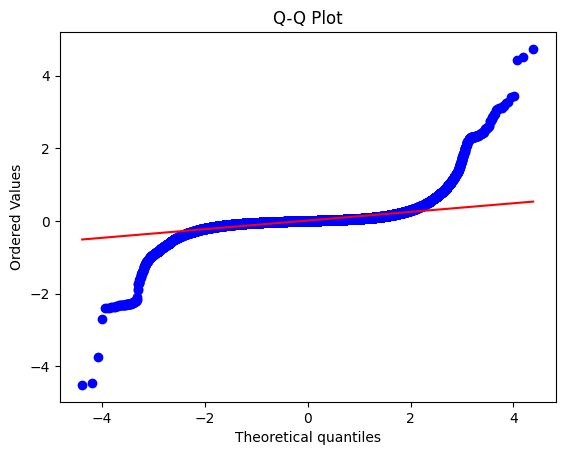

In [ ]:
ZD.plot_logerr_QQ(df=ZD.train)

Given the presence of outliers, let us remove extreme examples more than 3 standard deviations from the mean.

In [ ]:
def remove_outliers(data_df, n_stds=3):
    len_df = data_df.shape[0]
    high_thresh = data_df.logerror.mean() + n_stds * data_df.logerror.std()
    low_thresh = data_df.logerror.mean() - n_stds * data_df.logerror.std()
    trimmed_df = data_df[data_df.logerror < high_thresh]
    trimmed_df = trimmed_df[data_df.logerror > low_thresh]

    len_trimmed = trimmed_df.shape[0]
    print(f'{len_df - len_trimmed} of {len_df} outliers removed.')

    return trimmed_df

In [ ]:
trimmed_train = remove_outliers(ZD.train, n_stds=3)

1746 of 117521 outliers removed.


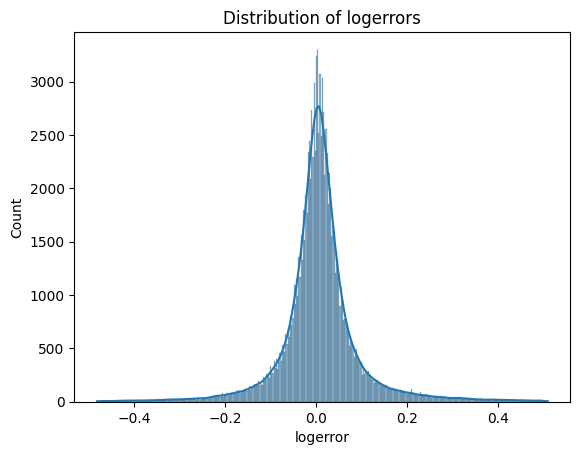

In [ ]:
ZD.plot_logerr_hist(df=trimmed_train)

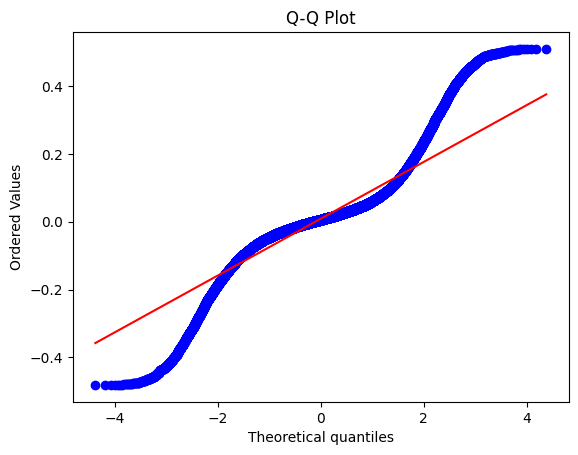

In [ ]:
ZD.plot_logerr_QQ(df=trimmed_train)

Now we update the train set after the outliers were removed. We do not touch the validation or test sets as that would be improper. The point of removing extreme outliers from the train set is to allow our models to focus on learning the general trend instead of trying to accomodate outlier cases.

In [ ]:
ZD.train = trimmed_train

Next form the datasets by separating the X data from the Y targets.

In [ ]:
ZD.form_datasets()

In [ ]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 59), Y shapes: (115775, 1)
Validation X shapes: (25184, 59),  Y shapes: (25184, 1)
Test X shapes:       (25183, 59),  Y shapes: (25183, 1)


## Missing data

In this section we are trying to fill the missing data. First we need to check how much missing data we have:

In [ ]:
train_na_ratio_df = ZillowData.get_missing_ratio_df(ZD.train_x)

Unfortunately nearly half of the data is missing.

In [ ]:
print(f'Average percent of missing data per column: {train_na_ratio_df.NAN_ratio.mean()*100:.1f}%')

Average percent of missing data per column: 47.6%


Each column's missing data ratio is shown below.

In [ ]:
train_na_ratio_df

,NAN_ratio
buildingclasstypeid,0.999845
finishedsquarefeet13,0.999594
storytypeid,0.999447
basementsqft,0.999447
yardbuildingsqft26,0.998955
fireplaceflag,0.997659
architecturalstyletypeid,0.997132
typeconstructiontypeid,0.996804
finishedsquarefeet6,0.995483
decktypeid,0.992477


## Handling of missing data


After finding out how many missing data we have, let's clean them by getting information about them and filling them up.

In [ ]:
ZD.clean_all_data()

In [ ]:
ZD.convert_column_type(col_type=np.float32)

In [ ]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 37), Y shapes: (115775, 1)
Validation X shapes: (25184, 37),  Y shapes: (25184, 1)
Test X shapes:       (25183, 37),  Y shapes: (25183, 1)


In [ ]:
ZD.train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115775 entries, 81426 to 13739
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   airconditioningtypeid         115775 non-null  float32
 1   bathroomcnt                   115775 non-null  float32
 2   bedroomcnt                    115775 non-null  float32
 3   buildingqualitytypeid         115775 non-null  float32
 4   decktypeid                    115775 non-null  float32
 5   calculatedfinishedsquarefeet  115775 non-null  float32
 6   finishedsquarefeet12          115775 non-null  float32
 7   fips                          115775 non-null  float32
 8   fireplacecnt                  115775 non-null  float32
 9   garagecarcnt                  115775 non-null  float32
 10  garagetotalsqft               115775 non-null  float32
 11  hashottuborspa                115775 non-null  float32
 12  heatingorsystemtypeid         115775 non-

Now, let's try to find the correlation between each of the parameters. This helps us to identify the important variables, remove the less important and redundant variables. We used heat map correlation plot to show the correlation between each variable.

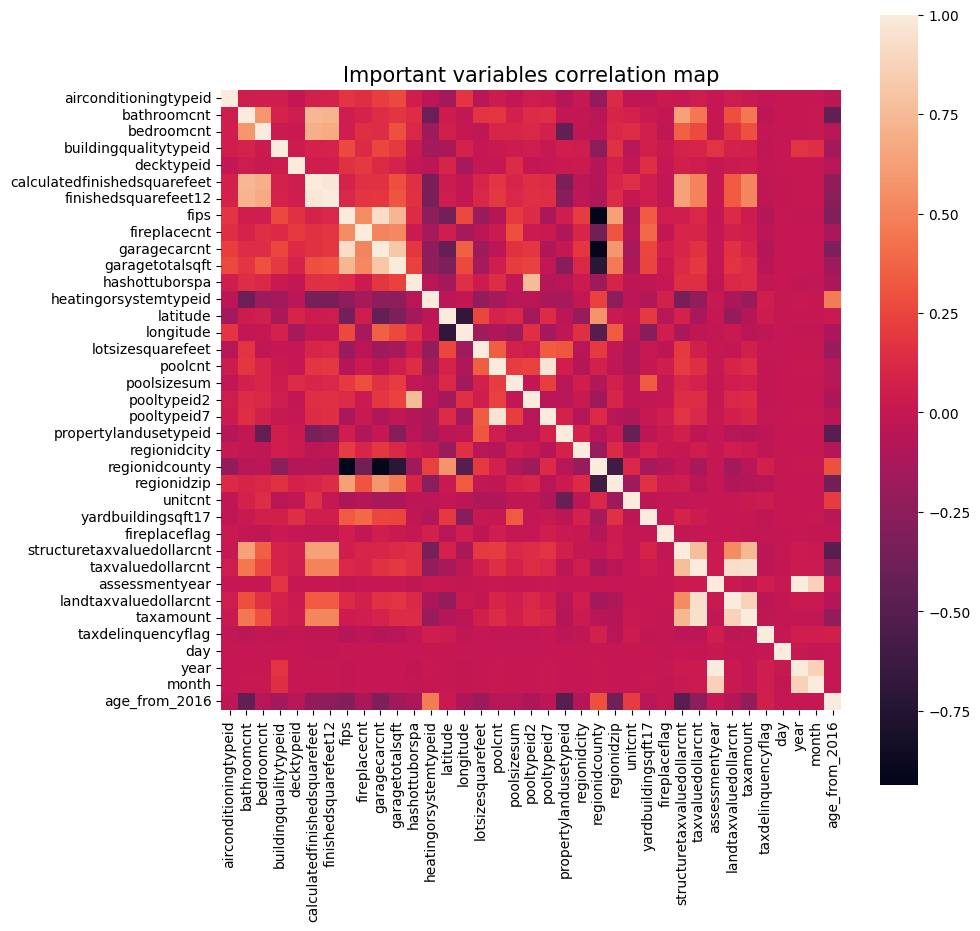

In [ ]:
corrmat = ZD.train_x.corr(method='spearman')

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

From the correlation map, we can see the following highly correlated columns:
 - Group 1: `(one of these two should be dropped)`
    - calculatedfinishedsquarefeet
    - finishedsquarefeet12
 - Group 2: `(one of these two should be dropped)`
    - poolcnt
    - pooltypeid7
 - Group 3: `(between one and three of these can be dropped)`
    - structuretaxvaluedollarcnt
    - taxvaluedollarcnt
    - landtaxvaluedollarcnt
    - taxdeliquencyflag
 - Group 4: `(year and month could potentially be dropped)`
    - assessmentyear
    - year
    - month

Now, let's see where the data sits Geographically. The Kaggle website mentioned that the data is coming from the LA, Orange and Ventura counties. So let's plot the data based on the longitude and latitude:

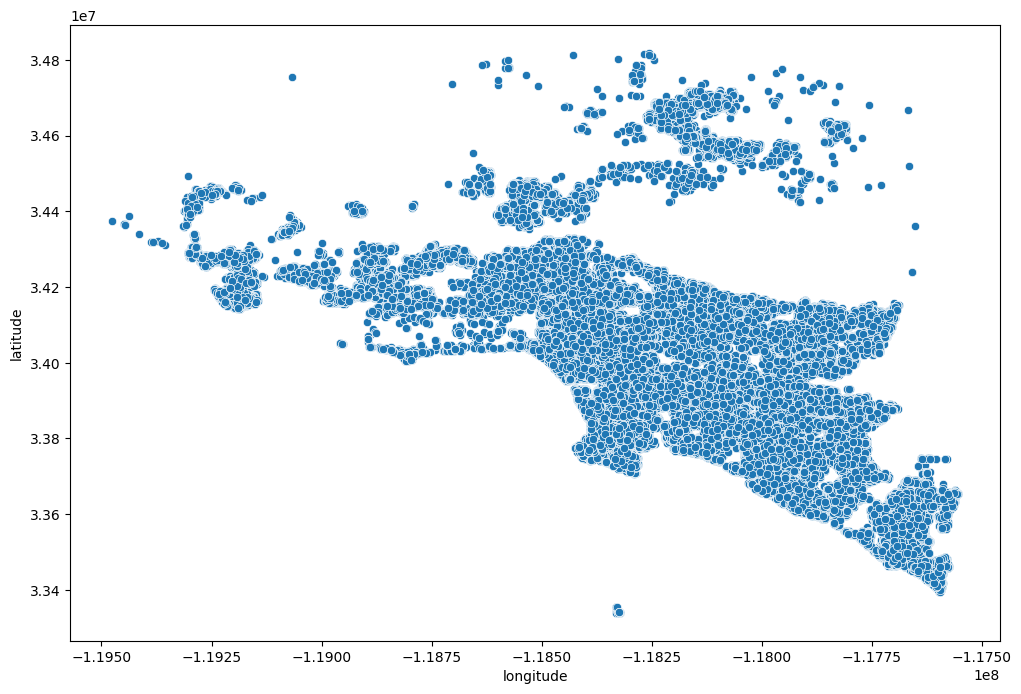

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude',y='latitude',data=ZD.train_x)
plt.show()

That pretty much very similar to google map picture. The border between the ocean and the land is clearly show in the above data. One note that needs to be consider is that most of the outliers are the expensive houses that are closest to the water. These houses usually have a high logerror values.

![](https://drive.google.com/uc?export=view&id=1ffaNzw2p8MJWOg3lHRQ98reoL1AlB4Oe)

# Feature Selection

We used ExtraTreesRegressor library from Sklearn library here to find which features are the most important ones. Sklearn uses other libraries such as Random Forest, Gradient Boosting, AdaBoost regressor libraries to perform regression tasks. We will study those libraries in depth later.

Also, we are getting rid of the below features since they don't have good correlation with data:

- "hashottuborspa"
- "propertycountylandusecode"
- "propertyzoningdesc"
- "fireplaceflag"
- "taxdelinquencyflag"

In [ ]:
ZD.train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115775 entries, 81426 to 13739
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   airconditioningtypeid         115775 non-null  float32
 1   bathroomcnt                   115775 non-null  float32
 2   bedroomcnt                    115775 non-null  float32
 3   buildingqualitytypeid         115775 non-null  float32
 4   decktypeid                    115775 non-null  float32
 5   calculatedfinishedsquarefeet  115775 non-null  float32
 6   finishedsquarefeet12          115775 non-null  float32
 7   fips                          115775 non-null  float32
 8   fireplacecnt                  115775 non-null  float32
 9   garagecarcnt                  115775 non-null  float32
 10  garagetotalsqft               115775 non-null  float32
 11  hashottuborspa                115775 non-null  float32
 12  heatingorsystemtypeid         115775 non-

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(ZD.train_x, ZD.train_y)

ExtraTreesRegressor(max_depth=30, max_features=0.3, n_estimators=25, n_jobs=-1,
                    random_state=0)

In [ ]:
## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

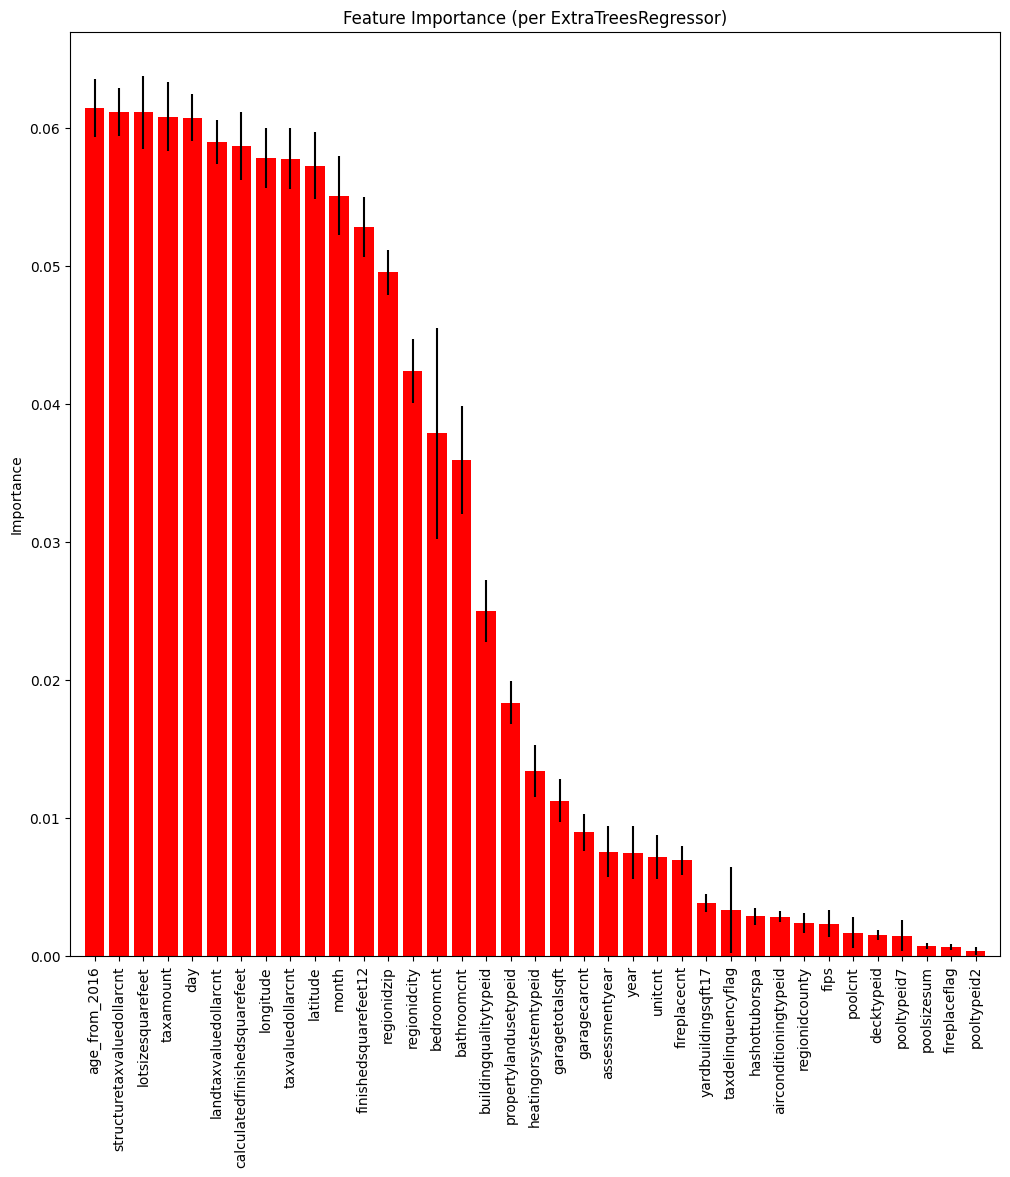

In [ ]:
plt.figure(figsize=(12,12))
plt.title("Feature Importance (per ExtraTreesRegressor)")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), ZD.train_x.columns.values[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.ylabel('Importance')
plt.show()

In [ ]:
# importing sklearn libraries
from sklearn.preprocessing import StandardScaler , RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split , cross_val_predict , RandomizedSearchCV
from sklearn.linear_model import Ridge , Lasso , ElasticNet
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [ ]:
#minmaxscalar = MinMaxScaler()
standardscalar = StandardScaler()

In [ ]:
ZD.train_x_normalized = standardscalar.fit_transform(ZD.train_x)
ZD.val_x_normalized = standardscalar.transform(ZD.val_x)

# ML Models

In the below ML models we use 'GridsearchCV' technique to find the best hyperparameters. GridSearchCV (Grid Search Cross-Validation) is a technique used to systematically search for the best combination of hyperparameters for a machine learning model. It's a common method for hyperparameter tuning, especially when we have a limited number of hyperparameters to tune and we want to explore all possible combinations of these hyperparameters. We used this for Lasso, Random Forest, XGBoost and KNN, Nueral Network models.

In below section, you will see the work for each ML model.

## Lasso

The Lasso regression model is a linear regression technique that includes L1 regularization, which encourages sparsity in the model coefficients. This can be useful for feature selection and handling multicollinearity.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Create the Lasso model
lasso_model = Lasso()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'alpha': 0.001}
Mean Squared Error: 0.024392506049123013
Mean Absolute Error: 0.0665652569630056


 The alpha parameter controls the strength of the regularization. A smaller alpha encourages stronger regularization and can lead to more coefficients being set to zero. We used alpha 0.01 here just to see how model works.

 Now let's plot our prediction and validation results to see how far they are from each other.

Text(0.5, 1.0, 'Prediction vs Validaion plot')

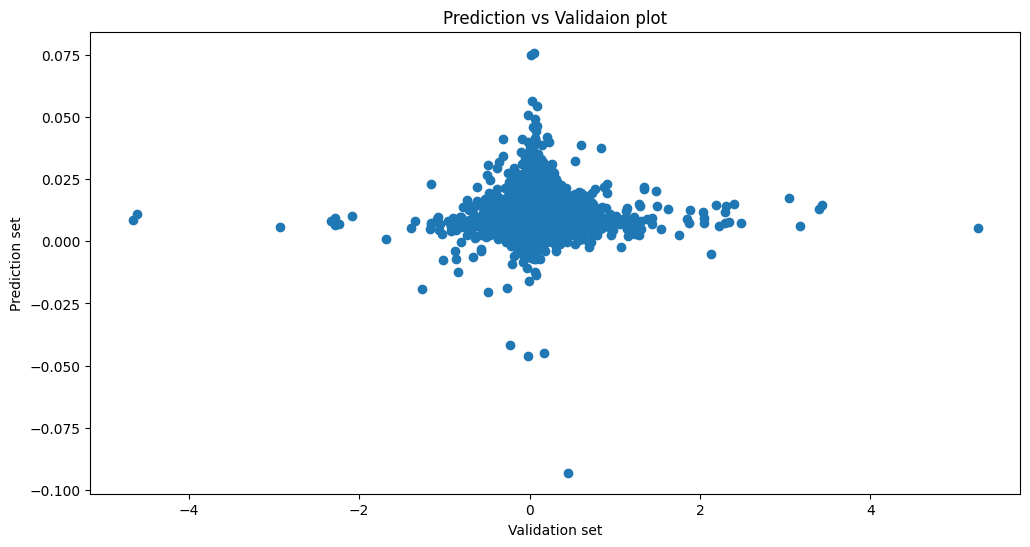

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Test set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

As it shown above most of the data are located near zero which means the logerror between prediction and test data set is close to each other which shows the model found a good agreement between prediction and test set.

## Random Forest Regressor

A Random Forest Regressor is an ensemble model for regression tasks. It combines multiple decision trees trained on random subsets of data to make accurate predictions. It's valuable because it reduces overfitting, handles complex relationships, provides feature importance, is robust, and is relatively easy to use.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 0.02423483574630849
Mean Absolute Error: 0.06644136658314007


Text(0.5, 1.0, 'Prediction vs Validaion plot')

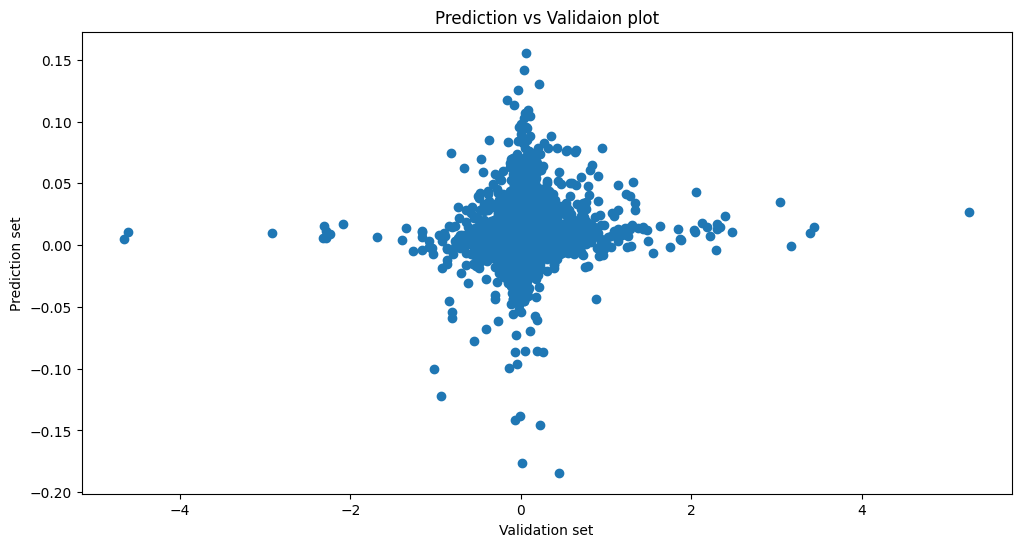

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Test set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

## XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that's popular for both classification and regression tasks. It's a boosting algorithm, which means it builds a strong predictive model by combining the predictions of multiple weaker models (usually decision trees) in a sequential manner.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Mean Squared Error: 0.024234096118360235
Mean Absolute Error: 0.06636125183802036


Text(0.5, 1.0, 'Prediction vs Validaion plot')

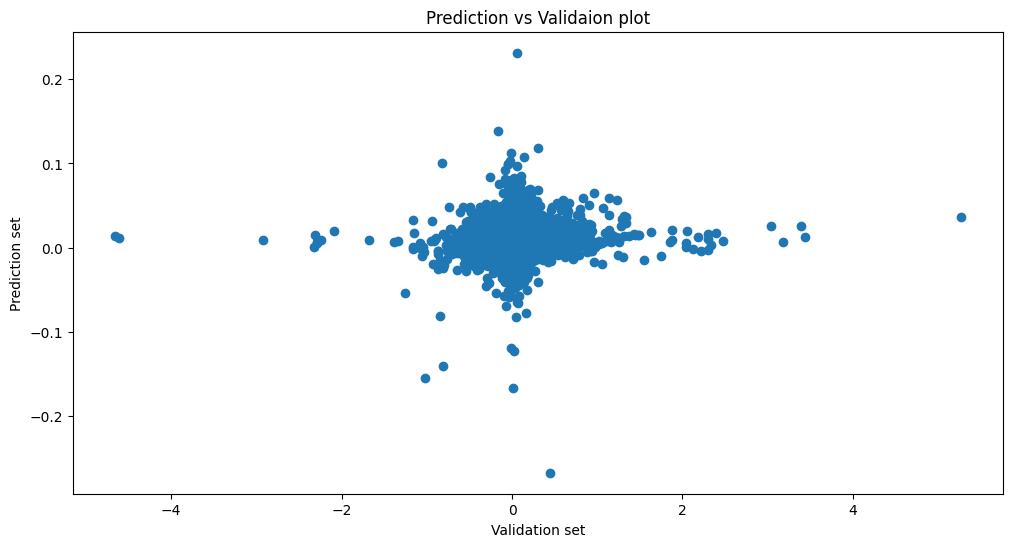

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Test set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

## kNN

Let's do the exact thing for the KNN. This method is famous enough so we didn't bring its definition here :)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Create the KNN model
knn_model = KNeighborsRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search to your data
grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for prediction
y_pred = best_model.predict(ZD.val_x_normalized)

# Evaluate the model's performance
mse = mean_squared_error(ZD.val_y, y_pred)
mae = mean_absolute_error(ZD.val_y, y_pred)
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'n_neighbors': 9}
Mean Squared Error: 0.0249971451284804
Mean Absolute Error: 0.07143900255417508


Text(0.5, 1.0, 'Prediction vs Validaion plot')

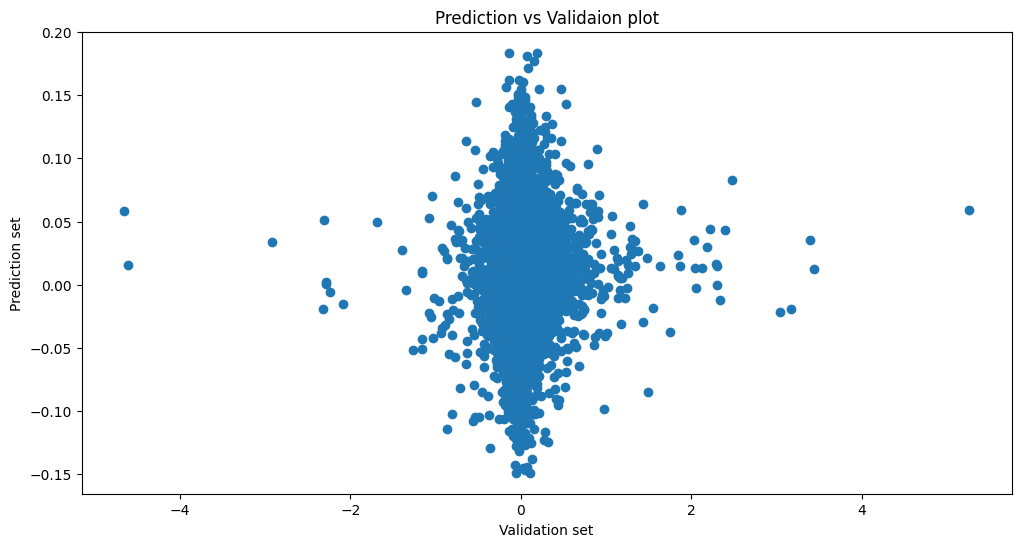

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(ZD.val_y, y_pred)
plt.xlabel('Validation set')
plt.ylabel('Prediction set')
plt.title('Prediction vs Test plot')

## Neural Network

For Neural Network the gridsearch method was also used. The selected hyperparameters to optimzed were: batch_size, learning_rate, neurons_layer1,neurons_layer2, dropout_rate, regularization_rate. Since, the running these were taking so long. We commented out the original section and provide the best results in the next code cell.

In [ ]:
#Last version with the grid search
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.001, neurons_layer1=64, neurons_layer2=32, dropout_rate=0.3, regularization_rate=0.01):
    model = Sequential()

    model.add(Dense(neurons_layer1, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(neurons_layer2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

model = KerasRegressor(build_fn=create_model, epochs=20)

param_grid = {
    'batch_size': [256, 512],
    'learning_rate': [0.001, 0.0005],
    'neurons_layer1': [64, 128],
    'neurons_layer2': [32, 64],
    'dropout_rate': [ 0.2, 0.3],
    'regularization_rate': [0.01, 0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(ZD.train_x_normalized, ZD.train_y)

print("Best parameters:", grid_result.best_params_)

best model came with these parameters:
Best parameters: {'batch_size': 512, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'neurons_layer1': 128, 'neurons_layer2': 32, 'regularization_rate': 0.001}

So we are using the above results just to run the NN once and create the plots.

In [ ]:
#Last version with the grid search
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.001, neurons_layer1=64, neurons_layer2=32, dropout_rate=0.3, regularization_rate=0.01):
    model = Sequential()

    model.add(Dense(neurons_layer1, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(neurons_layer2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

model = KerasRegressor(build_fn=create_model, epochs=20)

param_grid = {
    'batch_size': [512],
    'learning_rate': [0.001],
    'neurons_layer1': [128],
    'neurons_layer2': [32],
    'dropout_rate': [ 0.2],
    'regularization_rate': [0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(ZD.train_x_normalized, ZD.train_y)

print("Best parameters:", grid_result.best_params_)

Epoch 1/20
151/151 [==============================] - 3s 6ms/step - loss: 0.1725
Epoch 2/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0922
Epoch 3/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0728
Epoch 4/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0586
Epoch 5/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0480
Epoch 6/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0395
Epoch 7/20
151/151 [==============================] - 1s 5ms/step - loss: 0.0332
Epoch 8/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0284
Epoch 9/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0245
Epoch 10/20
151/151 [==============================] - 1s 6ms/step - loss: 0.0216
Epoch 11/20
151/151 [==============================] - 1s 7ms/step - loss: 0.0193
Epoch 12/20
151/151 [==============================] - 1s 7ms/step - loss: 0.0173
Epoch 13/20
151/151 [====

In [ ]:
best_model = grid_result.best_estimator_.model
predictions = best_model.predict(ZD.val_x_normalized)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(ZD.val_y, predictions)
mae = mean_absolute_error(ZD.val_y, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

787/787 [==============================] - 1s 1ms/step
Mean Squared Error: 0.024435376259417142
Mean Absolute Error: 0.0665953296757014


answer is:
787/787 [==============================] - 1s 1ms/step
Mean Squared Error: 0.029026304043712543
Mean Absolute Error: 0.06849104287466867

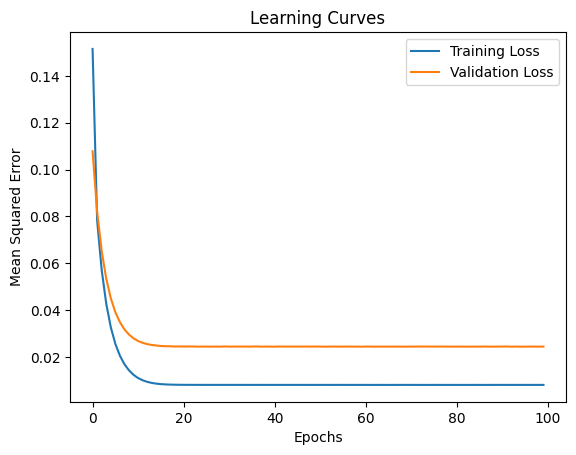

In [ ]:
#best model ploting
best_params = grid_result.best_params_


batch_size = best_params.pop('batch_size')


best_model = create_model(**best_params)


history = best_model.fit(
    ZD.train_x_normalized, ZD.train_y,
    epochs=100,
    validation_data=(ZD.val_x_normalized, ZD.val_y),
    batch_size=batch_size,
    verbose=0
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Results
So let's put a chart for all of the model that we have been tried so far and see what we got.

| Model name | MSE |  MAE | Hyperparameters selection
|:-:                |:-:                  |:-:           |:-:       |
|**Baseline**              | 0.165                 | 0.0697           | -
| **Lasso**              | 0.0249                | 0.0666       | learning rate   
| **Random Forest**      | 0.0242                | 0.0669   | n_estimators, max_depth, min_samples_split
| **XGBoost**            | 0.0242                | 0.0663   | n_estimators, max_depth, learning_rate, subsample
| **KNN**                | 0.0250                |  0.714   |  n_neighbors
| **CNN**                | 0.0290                | 0.068    | batch_size, learning_rate, neurons_layers, dropout_rate, regularization_rate

The overall performance of the models surpassed that of the baseline, indicating substantial improvement. Notably, among the models employed, Random Forest and XGBoost demonstrated superior predictive capabilities for the test data.

# Winners

First, let's see who took the million dollar home! The winners for this competition and their story can be found in the link below:


[link to the Winners website](https://www.zillow.com/z/info/zillow-prize/#:~:text=Meet%20the%20Zillow%20Prize%20Champions,time%20zones%20foil%20their%20efforts.)

We decided to participate in the challenge and see how our models works among the others. We picked XGBoost as our best model and submit the results to the Kaggle. After submitting we got 0.0758 private score. This put us around 2000th rank among 3770 participants.

![](https://drive.google.com/uc?export=view&id=17KeBV-IBjySx5hdj1ff-CdgHZ7Y0z-dT)

# Conclusion
This project aimed to predict Zillow Pricing using various machine learning models. The initial phase involved extensive data cleaning, followed by the identification of crucial features using correlation analysis. Subsequently, a range of ML models, including Lasso, Random Forest, XGBoost, KNN, and Neural Network, were employed to predict the test data. Additionally, a grid search method was applied to identify optimal hyperparameters for each model, ensuring the best possible solutions.

For future enhancements, the dataset will be expanded to include data from 2017, enhancing the generalizability of the model. Moreover, a more comprehensive approach to understanding the labels is necessary. The current output, provided in logerror format, lacks intuitive insight into the predicted dollar values. It would be valuable if the model could express its price estimates in specific dollar amounts, enhancing interpretability and usability.
